#### Pretrained models are from: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
#### Tutorial on deeplabv3+ : https://towardsdatascience.com/semantic-segmentation-of-150-classes-of-objects-with-5-lines-of-code-7f244fa96b6c
#### tutorial on ADE20k with tensorflow: https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=LaPKA60VTUX9

# Importing libraries

In [1]:
import pixellib
from pixellib.semantic import semantic_segmentation
#from pixellib.custom_train import instance_custom_training

In [2]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa


AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.6.2


# Creating variables

In [3]:
# Convert Checkpoint to model
cpk_path = "models/pretrained/deeplabv3_xception65_ade20k_train/" #frozen_inference_graph.pb
root = "gluonCV/"
dataset_path = root + "ADEChallengeData2016/images/"
training_data = "training/"
val_data = "validation/"
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 151
SEED = 26

# Creating a source dataset

In [4]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 20210 images.
The Validation Dataset contains 2000 images.


## Helper functions

In [5]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

## Loading dataset

In [6]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

## Applying some transformations to our dataset

In [7]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
BATCH_SIZE = 5

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


## Visualizing a sample

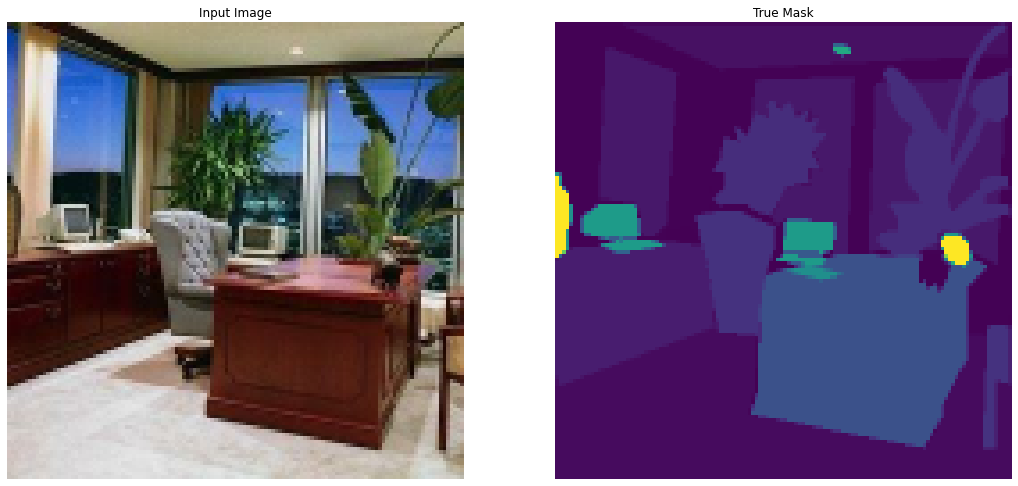

In [9]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

# Making it suitable for Zero Shot Problem

ValueError: in user code:

    <ipython-input-26-41ab8832a200>:31 None  *
        lambda image_file, class_name: load_image_and_label(class_name),
    <ipython-input-26-41ab8832a200>:8 load_image_and_label  *
        for image, mask in dataset['train'].take(1):
    C:\Users\15148\.conda\envs\tens\lib\site-packages\tensorflow\python\autograph\operators\control_flow.py:422 for_stmt
        iter_, extra_test, body, get_state, set_state, symbol_names, opts)
    C:\Users\15148\.conda\envs\tens\lib\site-packages\tensorflow\python\autograph\operators\control_flow.py:727 _tf_dataset_for_stmt
        _verify_loop_init_vars(init_vars, symbol_names)
    C:\Users\15148\.conda\envs\tens\lib\site-packages\tensorflow\python\autograph\operators\control_flow.py:191 _verify_loop_init_vars
        raise ValueError(error_msg)

    ValueError: 'mask' must be defined before the loop.


# Creating our model

## new UNET model

In [10]:
def create_Unet(w=IMG_SIZE, h=IMG_SIZE, channels=N_CHANNELS, dropout_rate=0.5):
    
    input_size = (w, h, channels)
    initializer = 'he_normal'


    # -- Encoder -- #
    # Block encoder 1
    inputs = Input(shape=input_size)
    conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
    conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

    # Block encoder 2
    max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
    conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
    conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

    # Block  encoder 3
    max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
    conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
    conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

    # Block  encoder 4
    max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
    conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
    conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
    # -- Encoder -- #

    # ----------- #
    maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
    conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
    conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
    # ----------- #

    # -- Dencoder -- #
    # Block decoder 1
    up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
    merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
    conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
    conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

    # Block decoder 2
    up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
    merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
    conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
    conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

    # Block decoder 3
    up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
    merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
    conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
    conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

    # Block decoder 4
    up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
    merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
    conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
    conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
    conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
    # -- Dencoder -- #

    output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)
    model = tf.keras.Model(inputs = inputs, outputs = output)
    return model


model = create_Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Load a pretrained DeepLabV3+

In [11]:
#segment_image = instance_custom_training()

#segment_image = semantic_segmentation()
#segment_image.load_ade20k_model("models/pretrained/deeplabv3_xception65_ade20k.h5")

In [12]:
#deeplabv3plus = segment_image.model2
#deeplabv3plus.summary()

## Resize all dataset to fit for deeplab expected input layer

In [13]:
# def preprocess_image(image, mask, desired_size=(512, 512)):
#     # Resize image and mask
#     resized_image = tf.image.resize(image, desired_size)
#     resized_mask = tf.image.resize(mask, desired_size, method='nearest')  # Using nearest neighbor to avoid introducing new classes in mask
#     return resized_image, resized_mask


# Apply the preprocessing function to each sample in the dataset
# dataset['train'] = dataset['train'].map(preprocess_image)

# Compiling and quick test

In [14]:
LR = 0.001
model.compile(optimizer=Adam(learning_rate=LR), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predicitons
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(model=model, dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

### Results with untrained unet

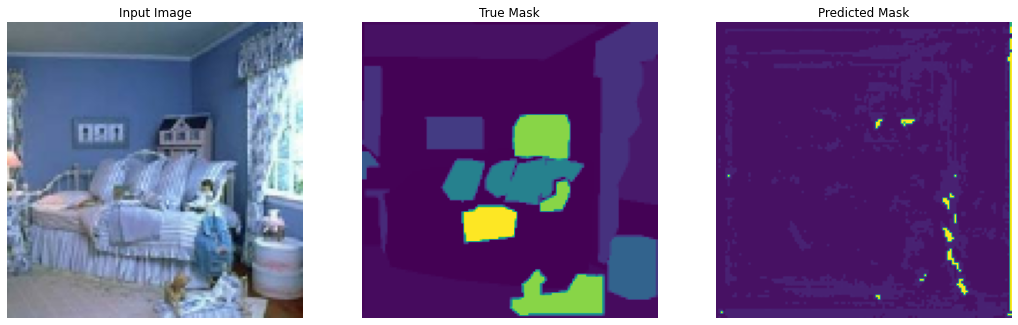

In [16]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions(model)

### Results with untrained DeepLabV3+

In [17]:
def preprocess_image(image, mask, desired_size=(512, 512)):
    # Resize image and mask
    resized_image = tf.image.resize(image, desired_size)
    resized_mask = tf.image.resize(mask, desired_size, method='nearest')  # Use nearest neighbor for the mask
    return resized_image, resized_mask

# Extract a single sample from the dataset
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = preprocess_image(image, mask)


# Now use resized_image and resized_mask for predictions or further processing
#show_predictions(model=deeplabv3plus)

# Training our model

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
def deeplab_process_batch(images, masks=None, desired_size=(512, 512)):
    # Resize images and masks
    resized_images = tf.image.resize(images, desired_size)
    if masks is not None:
        resized_masks = tf.image.resize(masks, desired_size, method='nearest')
    else:
        resized_masks = None
    return resized_images, resized_masks

def process_batch_wrapper(images, masks):
    resized_images, resized_masks = deeplab_process_batch(images, masks)
    return (resized_images, resized_masks)

# Unbatch the original dataset
dataset_unbatched_train = dataset['train'].unbatch()
dataset_unbatched_val = dataset['val'].unbatch()

# Apply the resizing function to each item in the dataset
dataset_modified = {}
dataset_modified['train'] = dataset_unbatched_train.map(process_batch_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_modified['val'] = dataset_unbatched_val.map(process_batch_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Rebatch the dataset
dataset_modified['train'] = dataset_modified['train'].batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
dataset_modified['val'] = dataset_modified['val'].batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Inspect the modified dataset structure
for images, masks in dataset_modified['train'].take(1):
    print("Modified shape:", images.shape, masks.shape)

Modified shape: (5, 512, 512, 3) (5, 512, 512, 1)


In [20]:
#model=deeplabv3plus

In [24]:
EPOCHS = 10
LR = 1e-3

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    #DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_deeplabv3plus.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

optimizer=tfa.optimizers.RectifiedAdam(lr=LR)
#optimizer=Adam(learning_rate=LR)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss = loss,
              metrics=['accuracy'])

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

In [25]:
# On CPU
# with tf.device("/cpu:0"):
#     model_history = model.fit(dataset['train'], epochs=EPOCHS,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=dataset['val'])

# On GPU
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks=callbacks)

Epoch 1/10
4042/4042 [==============================] - 385s 94ms/step - loss: 3.3282 - accuracy: 0.2295 - val_loss: 3.2565 - val_accuracy: 0.2310

Epoch 00001: val_loss improved from inf to 3.25654, saving model to best_model_deeplabv3plus.h5
Epoch 2/10
4042/4042 [==============================] - 381s 94ms/step - loss: 3.0247 - accuracy: 0.2827 - val_loss: 2.9350 - val_accuracy: 0.3157

Epoch 00002: val_loss improved from 3.25654 to 2.93504, saving model to best_model_deeplabv3plus.h5
Epoch 3/10
4042/4042 [==============================] - 400s 99ms/step - loss: 2.8881 - accuracy: 0.3287 - val_loss: 2.8300 - val_accuracy: 0.3534

Epoch 00003: val_loss improved from 2.93504 to 2.82999, saving model to best_model_deeplabv3plus.h5
Epoch 4/10
4042/4042 [==============================] - 378s 94ms/step - loss: 2.8123 - accuracy: 0.3495 - val_loss: 2.7960 - val_accuracy: 0.3494

Epoch 00004: val_loss improved from 2.82999 to 2.79597, saving model to best_model_deeplabv3plus.h5
Epoch 5/10
4

# Evaluation

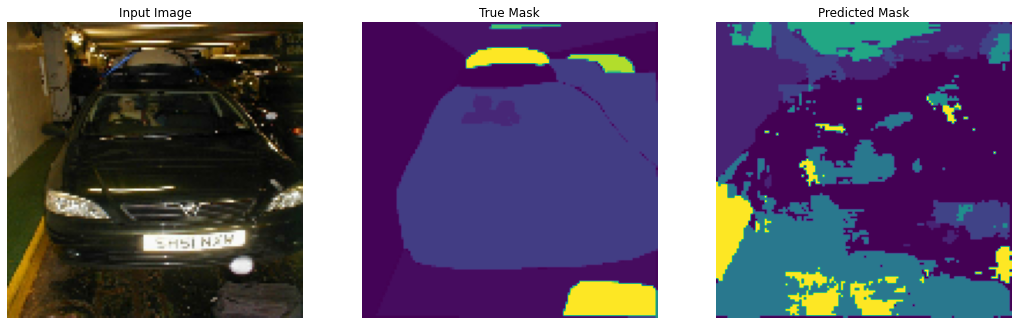

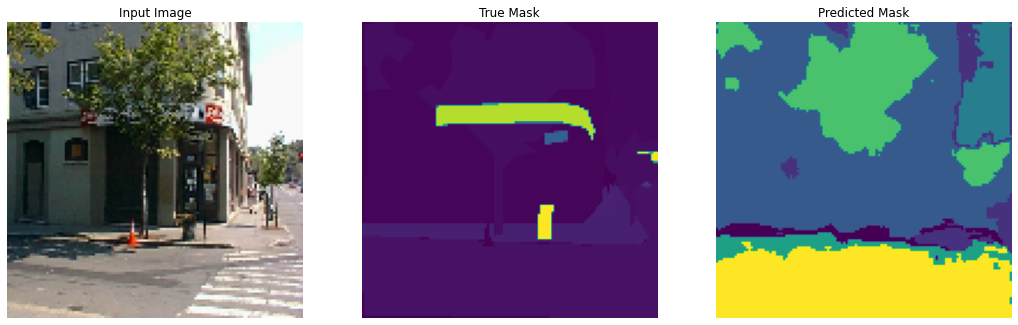

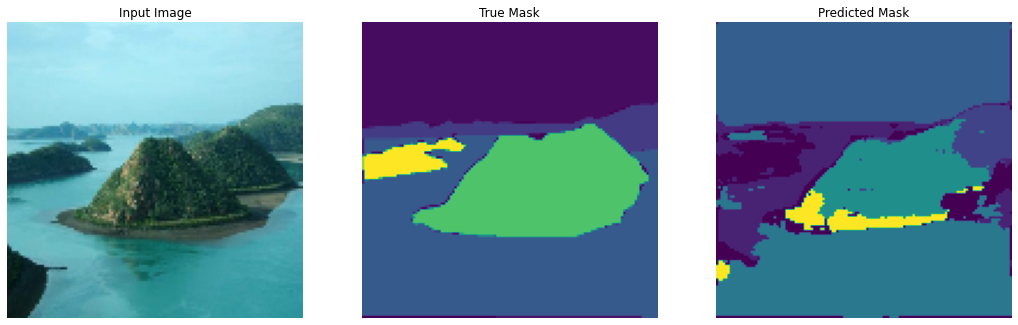

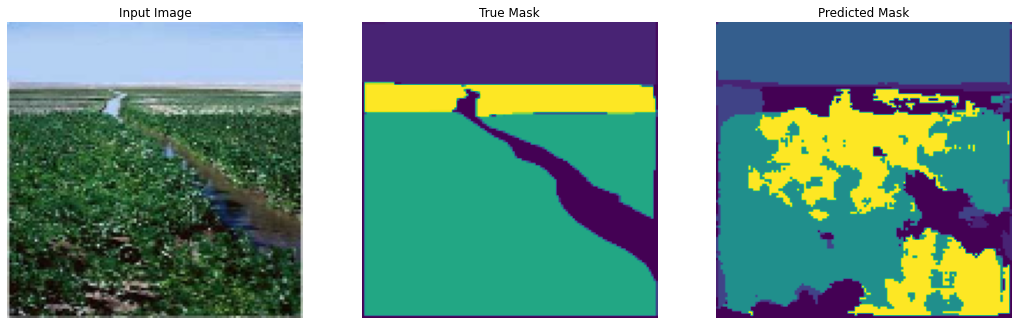

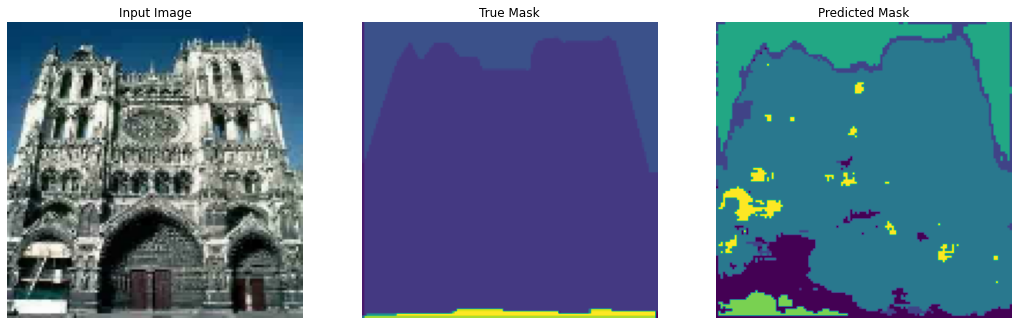

In [29]:
# for i in range(5):
#     for image, mask in dataset['train'].take(1):
#         sample_image, sample_mask = preprocess_image(image, mask)

#     show_predictions()
    
    
    
def preprocess_image(image, mask, desired_size=(512, 512)):
    # Resize image and mask
    resized_image = tf.image.resize(image, desired_size)
    resized_mask = tf.image.resize(mask, desired_size, method='nearest')  # Use nearest neighbor for the mask
    return resized_image, resized_mask


for i in range(5):
    # Extract a single sample from the dataset
    for image, mask in dataset['train'].take(1):
        sample_image, sample_mask = image, mask


    # Now use resized_image and resized_mask for predictions or further processing
    show_predictions()

# Model Evaluation

In [31]:
# Metrics
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
miou_metric = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)  # Replace NUM_CLASSES with your actual number of classes

# Accumulate metrics over the validation set
for image_batch, mask_batch in dataset['val'].take(VALIDATION_STEPS):
    # Make predictions
    predictions = model.predict(image_batch)

    # Update metrics
    accuracy_metric.update_state(mask_batch, predictions)
    # For mIoU, you need to convert predictions to discrete values (e.g., using argmax)
    predicted_classes = tf.argmax(predictions, axis=-1)
    #miou_metric.update_state(mask_batch, predicted_classes)

# Get final metric results
accuracy = accuracy_metric.result().numpy()
#miou = miou_metric.result().numpy()

# Clear the state of the metrics
accuracy_metric.reset_states()
#miou_metric.reset_states()

# Print the results
print(f"Accuracy on Validation Set: {accuracy}")
#print(f"Mean IoU on Validation Set: {miou}")

Accuracy on Validation Set: 0.40429770946502686


In [43]:
def deeplab_process_batch(images, masks=None, desired_size=(512, 512)):
    # Resize images and masks
    resized_images = tf.image.resize(images, desired_size)
    if masks!=None:
        resized_masks = tf.image.resize(masks, desired_size, method='nearest')  # Use nearest neighbor for the masks
    else:
        resized_masks = None
    return resized_images, resized_masks


# Metrics
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Accumulate metrics over the validation set
for image_batch, mask_batch in dataset['val'].take(VALIDATION_STEPS):
    image_batch, mask_batch = deeplab_process_batch(image_batch, mask_batch)
    # Make predictions
    predictions = deeplabv3plus.predict(image_batch)

    # Update metrics
    accuracy_metric.update_state(mask_batch, predictions)
    # For mIoU, you need to convert predictions to discrete values (e.g., using argmax)
    predicted_classes = tf.argmax(predictions, axis=-1)

# Get final metric results
accuracy = accuracy_metric.result().numpy()

# Clear the state of the metrics
accuracy_metric.reset_states()

# Print the results
print(f"DeepLabV3Plus Accuracy on Validation Set: {accuracy}")

DeepLabV3Plus Accuracy on Validation Set: 0.6476088762283325


In [34]:
import pandas as pd
from tqdm import tqdm


def deeplab_process_batch(images, masks=None, desired_size=(512, 512)):
    # Resize images and masks
    resized_images = tf.image.resize(images, desired_size)
    if masks is not None:
        resized_masks = tf.image.resize(masks, desired_size, method='nearest')  # Use nearest neighbor for the masks
    else:
        resized_masks = None
    return resized_images, resized_masks

# Initialize dictionary to store accuracy for each class
accuracy_per_class = {f'Class_{i}': tf.keras.metrics.Accuracy() for i in range(N_CLASSES)}

# Accumulate metrics over the validation set
for image_batch, mask_batch in tqdm(dataset['val'].take(VALIDATION_STEPS)):
    image_batch, mask_batch = image_batch, mask_batch
    # Make predictions
    predictions = model.predict(image_batch)
    predicted_classes = tf.argmax(predictions, axis=-1)

    # Update per-class accuracy
    for i in range(N_CLASSES):
        # Create masks for each class
        true_mask = tf.equal(mask_batch, i)
        pred_mask = tf.equal(predicted_classes, i)

        # Update accuracy for the class
        accuracy_per_class[f'Class_{i}'].update_state(true_mask, pred_mask)

# Extract the final accuracy results for each class
accuracy_results = {class_id: metric.result().numpy() for class_id, metric in accuracy_per_class.items()}

# Clear the state of the metrics
for metric in accuracy_per_class.values():
    metric.reset_states()

# Convert to pandas DataFrame for easy viewing
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Class', 'Accuracy'])

# Print the DataFrame
print(accuracy_df)


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:41<00:00,  3.95it/s]

         Class  Accuracy
0      Class_0  0.825441
1      Class_1  0.781129
2      Class_2  0.850823
3      Class_3  0.977341
4      Class_4  0.869665
..         ...       ...
146  Class_146  0.999895
147  Class_147  0.999705
148  Class_148  0.999643
149  Class_149  0.999840
150  Class_150  0.999729

[151 rows x 2 columns]


In [35]:
accuracy_df.to_excel("Unet_original_trained_perClass_acc.xlsx")  

In [60]:
# Original:
# DeepLabV3Plus Original Accuracy on Validation Set: 0.6476088762283325

# After training:
#Epoch 00002: val_loss improved from 4.10247 to 3.73493, saving model to best_model_deeplabv3plus_trained.h5
#DeepLabV3Plus Accuracy on Validation Set: 0.6090981960296631
!pip install openpyxl